# Semantic Segmentation
Word of warning. This model needs 6-7GB of VRAM and can take multiple days to get ok results

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
import scipy.misc as misc
from IPython.display import Image, display
import os
import copy
import pickle

In [3]:
image_size = 224
num_classes = 151
batch_size = 3

model_name = "FCNMITADAM"
model_directory = os.getcwd() + "/SavedModel/" + model_name
model_filename = model_name + "Model.ckpt"
model_path = model_directory + "/" + model_filename

# Load Data from Scratch

In [3]:
def list_files(dire):
    r= []
    names = []
    for root, dirs, files in os.walk(dire):
        for name in files:
            r.append(dire+'/' + name)
    return r

In [5]:
with open(os.getcwd() + "/VOC2012/ImageSets/Segmentation/train.txt") as f:
    training_list = f.read().splitlines()
with open(os.getcwd() + "/VOC2012/ImageSets/Segmentation/val.txt") as f:
    validation_list = f.read().splitlines()  

In [6]:
training_images = [os.getcwd() + "/VOC2012/JPEGImages/" + s + ".jpg" for s in training_list]
training_labels = [os.getcwd() + "/VOC2012/SegmentationClass/" + s + ".png" for s in training_list]

In [7]:
validation_images = [os.getcwd() + "/VOC2012/JPEGImages/" + s + ".jpg" for s in validation_list]
validation_labels = [os.getcwd() + "/VOC2012/SegmentationClass/" + s + ".png" for s in validation_list]

In [7]:
def imageToArray(filename, size):
    image = misc.imread(filename)
    resize_image = misc.imresize(image, [size, size], interp='nearest')
    
    return np.array(resize_image)

def loadDataSet(data_list, label_list):
    dataset = []
    dataset_labels = []
    for filename in data_list:
        dataset.append(np.array(imageToArray(filename, image_size)))
    for filename in label_list:
        dataset_labels.append(np.array(imageToArray(filename, image_size)))

    return dataset, dataset_labels

In [8]:
training_data, training_labels = loadDataSet(training_list, training_label_list)

In [9]:
validation_data, validation_labels = loadDataSet(validation_list, validation_label_list)

# Load Data if Cached

In [1]:
import pickle

def cacheData(data_name, label_name, data, label):
    with open(data_name, 'wb') as f:
        pickle.dump(data, f)
    with open(label_name, 'wb') as f:
        pickle.dump(label, f)
        
def loadData(data_name, label_name):
    data = pickle.load(open(data_name, 'rb'))
    label = pickle.load(open(label_name, 'rb'))
    return data, label

In [2]:
validation_data, validation_labels = loadData('VOC_valid_data.pkl', 'VOC_valid_labels.pkl')

training_data, training_labels = loadData('VOC_training_data2.pkl', 'VOC_training_labels2.pkl')

### Cache Data

In [126]:
cacheData('VOvalid_data2.pkl', 'VOC_valid_labels2.pkl', validation_data, validation_labels)
cacheData('VOC_training_data2.pkl', 'VOC_training_labels2.pkl', training_data, training_labels)

In [10]:
validation_data = np.array(validation_data).reshape(-1, 224, 224, 3)
validation_labels = np.array(validation_labels).reshape(-1, 224, 224)
validation_predictions = np.array(validation_predictions).reshape(-1, 224, 224)

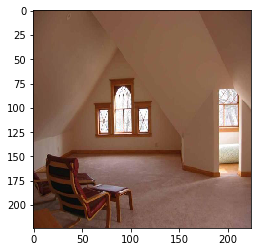

In [31]:
i = 1500

plt.imshow(validation_data[i], cmap="Paired")

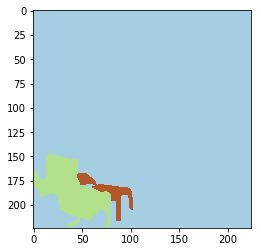

In [32]:
plt.imshow(np.squeeze(validation_labels[i]), cmap="Paired")

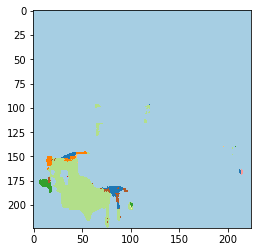

In [33]:
plt.imshow(validation_predictions[i], cmap="Paired")

# Build Network

In [7]:
def createConvolutionLayerNew(x_input, kernel_size, features, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # features - number of feature kernels
    # depth - number of feature kernels
    #
    # returns convolution layer in graph
    #
    #print("conv: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', initializer = tf.truncated_normal([kernel_size, kernel_size, features, depth], stddev=0.0001))

    biases = tf.get_variable('biases', shape=[depth], initializer=tf.constant_initializer(0))

    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    print("wF: " + str(weights.get_shape()))
    print("bF: " + str(biases.get_shape()))
    added = tf.nn.bias_add(convolution, biases)
    total_parameters = kernel_size*kernel_size*features*depth + depth
    print("Created Convolution Layer: Input" + str(x_input.get_shape()) + " Parameters(" + str(total_parameters) + ")")
    
    return tf.nn.relu(added)

In [8]:
def createConvolutionLayer(x_input, _weights, _biases, kernel_size, features, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # depth - number of feature kernels
    #
    # returns convolution layer in graph
    # 
    weights = tf.get_variable('weights', initializer=tf.constant_initializer(np.transpose(_weights, (1, 0, 2, 3)), dtype=tf.float32),  shape=_weights.shape)
    
    biases = tf.get_variable('biases', initializer=tf.constant_initializer(_biases.reshape(-1), dtype=tf.float32),  shape=_biases.reshape(-1).shape)
    
    #print("conv: input size: " + str(x_input.get_shape()))
    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    
    print("w: " + str(weights.get_shape()))
    print("b: " + str(biases.get_shape()))
    added = tf.nn.bias_add(convolution, biases)
    
    total_parameters = kernel_size*kernel_size*features*depth + depth
    print("Created Convolution Layer: Input" + str(x_input.get_shape()) + " Parameters(" + str(total_parameters) + ")")
    
    return tf.nn.relu(added)

In [9]:
def createConvolutionTransposeLayer(x_input, output_shape, weight_shape, stride=2):
        
    weights = tf.get_variable('weights', initializer = tf.truncated_normal(weight_shape, stddev=0.0001))
    biases = tf.get_variable('biases', shape=[weight_shape[2]], initializer=tf.constant_initializer(0))
    print("xInp: " + str(x_input.get_shape()))
    print("xOut: " + str(output_shape.get_shape()))
    print("wTrans: " + str(weights.get_shape()))
    print("bTrans: " + str(biases.get_shape()))
    
    convolution = tf.nn.conv2d_transpose(x_input, weights, output_shape, strides=[1,stride,stride,1], padding = 'SAME')
    return tf.nn.bias_add(convolution, biases)

In [10]:
def createFullyConnectedLayer(x_input, width):
    # createFullyConnectedLayer generates a fully connected layer in the session graph
    # 
    # x_input - output from previous layer
    # width - width of the layer (eg for a 10 class output you need to end with a 10 width layer
    #
    # returns fully connected layer in graph
    #
    #print("fc: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', shape=[x_input.get_shape()[1], width],
                             initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases', shape=[width], initializer=tf.constant_initializer(0))
     
    matrix_multiply = tf.matmul(x_input, weights)
    total_parameters = x_input.get_shape()[1] * width + width
    
    print("Created Fully Connected Layer: Input" + str(x_input.get_shape()) + " Parameters(" + str(total_parameters) + ")")
    
    return tf.nn.bias_add(matrix_multiply, biases)

In [11]:
def createLinearRectifier(x_input):
    # createLinearRectifier generates a ReLu in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # width - width of the layer
    #
    # returns ReLu in graph
    # 
    
    return tf.nn.relu(x_input)

In [12]:
def createPoolingLayer(x_input, kernel_size, pool_type):
    # createPoolingLayer generates a pooling layer in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # kernel_size - size of the kernel
    #
    # returns pooling layer in graph
    # 
    #print("pool: input size: " + str(x_input.get_shape()))
    #change to average pooling
    if pool_type == 'max':
        return tf.nn.max_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size, kernel_size, 1], padding='SAME')
    else:
        return tf.nn.avg_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size, kernel_size, 1], padding='SAME')
    

# Define VGG Model

In [22]:
#conv1.1 3x3, 64
#conv1.2 3x3, 64
#
#pool 2
#
#conv2.1 3x3, 128
#conv2.2 3x3, 128
#
#pool 2
#
#conv3.1 3x3, 256
#conv3.2 3x3, 256
#conv3.3 3x3, 256
#conv3.4 3x3, 256
#
#pool 2
#
#conv 4.1 3x3, 512
#conv 4.2 3x3, 512
#conv 4.3 3x3, 512
#conv 4.4 3x3, 512
#
#pool 2
#
#conv 5.1 3x3, 512
#conv 5.2 3x3, 512
#conv 5.3 3x3, 512
#conv 5.4 3x3, 512
#
#pool 2
#FC 4k
#FC 4k
#FC 1000

def createVGG19(x_input, layer_weights, is_training):
    
    with tf.variable_scope('conv11'):
        kernel_weights, bias_weights = layer_weights[0][0][0][0][0]
        convolution_layer11 = createConvolutionLayer(x_input, kernel_weights, bias_weights, 3, 1, 64)
    with tf.variable_scope('conv12'):
        kernel_weights, bias_weights = layer_weights[2][0][0][0][0]
        convolution_layer12 = createConvolutionLayer(convolution_layer11, kernel_weights, bias_weights, 3, 64, 64)
        pooling_layer1 = createPoolingLayer(convolution_layer12, 2, 'avg')
        
    with tf.variable_scope('conv21'):
        kernel_weights, bias_weights = layer_weights[5][0][0][0][0]
        convolution_layer21 = createConvolutionLayer(pooling_layer1, kernel_weights, bias_weights, 3, 64, 128)
    with tf.variable_scope('conv22'):
        kernel_weights, bias_weights = layer_weights[7][0][0][0][0]
        convolution_layer22 = createConvolutionLayer(convolution_layer21, kernel_weights, bias_weights, 3, 128, 128)
        pooling_layer2 = createPoolingLayer(convolution_layer22, 2, 'avg')
        
    with tf.variable_scope('conv31'):
        kernel_weights, bias_weights = layer_weights[10][0][0][0][0]
        convolution_layer31 = createConvolutionLayer(pooling_layer2, kernel_weights, bias_weights, 3, 1, 256)
    with tf.variable_scope('conv32'):
        kernel_weights, bias_weights = layer_weights[12][0][0][0][0]
        convolution_layer32 = createConvolutionLayer(convolution_layer31, kernel_weights, bias_weights, 3, 1, 256)
    with tf.variable_scope('conv33'):
        kernel_weights, bias_weights = layer_weights[14][0][0][0][0]
        convolution_layer33 = createConvolutionLayer(convolution_layer32, kernel_weights, bias_weights, 3, 1, 256)
    with tf.variable_scope('conv34'):
        kernel_weights, bias_weights = layer_weights[16][0][0][0][0]
        convolution_layer34 = createConvolutionLayer(convolution_layer33, kernel_weights, bias_weights, 3, 1, 256)
        pooling_layer3 = createPoolingLayer(convolution_layer34, 2, 'avg')
        
    with tf.variable_scope('conv41'):
        kernel_weights, bias_weights = layer_weights[19][0][0][0][0]
        convolution_layer41 = createConvolutionLayer(pooling_layer3, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv42'):
        kernel_weights, bias_weights = layer_weights[21][0][0][0][0]
        convolution_layer42 = createConvolutionLayer(convolution_layer41, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv43'):
        kernel_weights, bias_weights = layer_weights[23][0][0][0][0]
        convolution_layer43 = createConvolutionLayer(convolution_layer42, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv44'):
        kernel_weights, bias_weights = layer_weights[25][0][0][0][0]
        convolution_layer44 = createConvolutionLayer(convolution_layer43, kernel_weights, bias_weights, 3, 1, 512)
        pooling_layer4 = createPoolingLayer(convolution_layer44, 2, 'avg')
    
    with tf.variable_scope('conv51'):
        kernel_weights, bias_weights = layer_weights[28][0][0][0][0]
        convolution_layer51 = createConvolutionLayer(pooling_layer4, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv52'):
        kernel_weights, bias_weights = layer_weights[30][0][0][0][0]
        convolution_layer52 = createConvolutionLayer(convolution_layer51, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv53'):
        kernel_weights, bias_weights = layer_weights[32][0][0][0][0]
        convolution_layer53 = createConvolutionLayer(convolution_layer52, kernel_weights, bias_weights, 3, 1, 512)
    with tf.variable_scope('conv54'):
        kernel_weights, bias_weights = layer_weights[34][0][0][0][0]
        convolution_layer54 = createConvolutionLayer(convolution_layer53, kernel_weights, bias_weights, 3, 1, 512)
        pooling_layer5 = createPoolingLayer(convolution_layer53, 2, 'avg')
        
    with tf.variable_scope('fc1'):
        print('fc1')
        full_convolution_layer6 = createConvolutionLayerNew(pooling_layer5, 7, 512, 4096)
        fully_connected_relu6 = createLinearRectifier(full_convolution_layer6)
        fully_connected_relu6 = tf.cond(is_training, lambda: tf.nn.dropout(fully_connected_relu6, keep_prob = 0.85 if dropout else 1.0), lambda: fully_connected_relu6)
    
        
        #need dropout
    with tf.variable_scope('fc2'):
        full_convolution_layer7 = createConvolutionLayerNew(fully_connected_relu6, 1, 4096, 4096)
        fully_connected_relu7 = createLinearRectifier(full_convolution_layer7)
        fully_connected_relu7 = tf.cond(is_training, lambda: tf.nn.dropout(fully_connected_relu7, keep_prob = 0.85 if dropout else 1.0), lambda: fully_connected_relu7)
    
        # need dropout
    with tf.variable_scope('fc3'):
        full_convolution_layer8 = createConvolutionLayerNew(fully_connected_relu7, 1, 4096, num_classes)
        #full_convolution_layer8 = createConvolutionLayerNew(full_convolution_layer8, 3, 1, 512)
        
    return full_convolution_layer8, pooling_layer4, pooling_layer3

# Deconvolution Network

In [23]:
def createDeconvolutionNetwork(x_input, orig_input, pool_fuse1, pool_fuse2):
    
    with tf.variable_scope('dc1'):
        deconvolution_layer1 = createConvolutionTransposeLayer(x_input, tf.shape(pool_fuse1), [4, 4, pool_fuse1.get_shape()[3].value, num_classes], stride=2)
        print("dc1: " + str(deconvolution_layer1.get_shape()))
        #fuse layer with pool 4
        fuse_layer1 = tf.add(pool_fuse1, deconvolution_layer1)
        print("fuse1: " + str(fuse_layer1.get_shape()))
        
    with tf.variable_scope('dc2'):
        deconvolution_layer2 = createConvolutionTransposeLayer(fuse_layer1, tf.shape(pool_fuse2), [4, 4, pool_fuse2.get_shape()[3].value, pool_fuse1.get_shape()[3].value], stride=2)
        print("dc2: " + str(deconvolution_layer2.get_shape()))
        #fuse layer with pool 3
        fuse_layer2 = tf.add(pool_fuse2, deconvolution_layer2)
        print("fuse2: " + str(fuse_layer2.get_shape()))
        
    with tf.variable_scope('dc3'):
        #determine size
        shape1 = tf.shape(orig_input)
        shape2 = tf.pack([shape1[0], shape1[1], shape1[2], num_classes])
        #conv layer
        deconvolution_layer3 = createConvolutionTransposeLayer(fuse_layer2, shape2, [16, 16, num_classes, pool_fuse2.get_shape()[3].value], stride=8)
        print("output_layer: " + str(deconvolution_layer3.get_shape()))
        
    output = tf.argmax(deconvolution_layer3, dimension=3)
    
    return tf.expand_dims(output, dim=3), deconvolution_layer3

In [24]:
import scipy.io

def get_model_data(dir_path):
    filename = "imagenet-vgg-verydeep-19.mat"
    filepath = os.path.join(dir_path, filename)
    if not os.path.exists(filepath):
        print("Model File not found")
    data = scipy.io.loadmat(filepath)
    return data

In [25]:
model_data = get_model_data("model/")
mean = model_data['normalization'][0][0][0]
mean_pixel = np.mean(mean, axis=(0, 1))
weights = np.squeeze(model_data['layers'])

# Build Network

In [26]:
#Build the network
graph = tf.Graph()
with graph.as_default():
    
    dropout = True
    num_epochs = 5
    x_input = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3])
    y_output = tf.placeholder(tf.int32, shape=[None, image_size, image_size, 1])
    is_training = tf.placeholder(tf.bool)
    
    current_epoch = tf.Variable(0, trainable=False)
    increment_global_step_op = tf.assign(current_epoch, current_epoch+1)
    
    m_min = 0.9
    m_max = 0.99
    print("momentum increase on")
    momentum_rate = m_min + (m_max - m_min) * (current_epoch / 300)
    
    output, pool4, pool3 = createVGG19(x_input-mean_pixel, weights, is_training)
    prediction_output, logits = createDeconvolutionNetwork(output, x_input, pool4, pool3)

    learning_rate = .0001
    print(logits.get_shape())
    print(tf.squeeze(y_output, squeeze_dims=[3]).get_shape())
    
    loss_function = tf.reduce_mean((tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf.squeeze(y_output, squeeze_dims=[3]))))
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss_function)
    #optimizer = tf.train.GradientDescentOptimizer(0.00000000001).minimize(loss_function)

momentum increase on
w: (3, 3, 3, 64)
b: (64,)
Created Convolution Layer: Input(?, 224, 224, 3) Parameters(640)
w: (3, 3, 64, 64)
b: (64,)
Created Convolution Layer: Input(?, 224, 224, 64) Parameters(36928)
w: (3, 3, 64, 128)
b: (128,)
Created Convolution Layer: Input(?, 112, 112, 64) Parameters(73856)
w: (3, 3, 128, 128)
b: (128,)
Created Convolution Layer: Input(?, 112, 112, 128) Parameters(147584)
w: (3, 3, 128, 256)
b: (256,)
Created Convolution Layer: Input(?, 56, 56, 128) Parameters(2560)
w: (3, 3, 256, 256)
b: (256,)
Created Convolution Layer: Input(?, 56, 56, 256) Parameters(2560)
w: (3, 3, 256, 256)
b: (256,)
Created Convolution Layer: Input(?, 56, 56, 256) Parameters(2560)
w: (3, 3, 256, 256)
b: (256,)
Created Convolution Layer: Input(?, 56, 56, 256) Parameters(2560)
w: (3, 3, 256, 512)
b: (512,)
Created Convolution Layer: Input(?, 28, 28, 256) Parameters(5120)
w: (3, 3, 512, 512)
b: (512,)
Created Convolution Layer: Input(?, 28, 28, 512) Parameters(5120)
w: (3, 3, 512, 512)


In [27]:
class Batcher(object):
    def __init__(self, batch_size, shuffle=False, seed=42):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random = np.random.RandomState(seed)

    def __call__(self, images, labels=None):
        if self.shuffle:
            _shuffle_arrays([images, labels] if labels is not None else [images], self.random)
        self.images, self.labels = images, labels
        return self

        
    def __iter__(self):
        bs = self.batch_size
        for i in range((self.n_samples + bs - 1) // bs):
            sl = slice(i * bs, (i + 1) * bs)
            image_batch = _sldict(self.images, sl)
            if self.labels is not None:
                label_batch = _sldict(self.labels, sl)
            else:
                label_batch = None
            yield self.transform(image_batch, label_batch)
            

    @property
    def n_samples(self):
        images = self.images
        if isinstance(images, dict):
            return len(list(images.values())[0])
        else:
            return len(images)

    def transform(self, image_batch, label_batch):
        return image_batch, label_batch

    def __getstate__(self):
        state = dict(self.__dict__)
        for attr in ('X', 'y',):
            if attr in state:
                del state[attr]
        return state
    
def _sldict(array, _slice):
    if isinstance(array, dict):
        return {k: v[_slice] for k, v in array.items()}
    else:
        return array[_slice]

def _shuffle_arrays(arrays, random):
    rstate = random.get_state()
    for array in arrays:
        if isinstance(array, dict):
            for v in list(array.values()):
                random.set_state(rstate)
                random.shuffle(v)
        else:
            random.set_state(rstate)
            random.shuffle(array)

In [28]:
import time
def getTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return h, m, s

def savePrediction(path, name, step, image, session):
    filepath = os.path.join(path, name)
    if not os.path.exists(filepath):
        os.mkdir(filepath)
    [predict] = session.run([prediction_output], feed_dict={x_input: np.reshape(image, [1, 224, 224, 3]), is_training:False})
    pred = np.squeeze(predict, axis=3)
    pred = np.reshape(pred, [224, 224, 1])
    misc.imsave(os.path.join(filepath, str(name) + 'step' + str(step) + '.jpg'), np.squeeze(pred))
    
def averagePredictions(data, labels, batch_size, session):
    loss_list = []

    loop_end = len(data)-batch_size+1
    for i in range(0, loop_end):
        end = i + batch_size-1
        if end > loop_end:
            end = loop_end
        loss = session.run(loss_function, feed_dict={x_input: data[i:end], y_output: labels[i:end], is_training:False})
        loss_list.append(loss)
    return np.average(loss_list)

def saveModelHistory(epoch_list, time_list, train_loss_list, valid_loss_list, name):
    df = pd.DataFrame({'Epochs' : epoch_list, 'Time' :  time_list, 'Train': train_loss_list, 'Valid' : valid_loss_list})
    writer = pd.ExcelWriter(model_path + name + '.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name='Sheet1')
    writer.save()

In [32]:
training_labels = np.reshape(training_labels, [-1, image_size, image_size, 1])
validation_labels = np.reshape(validation_labels, [-1, image_size, image_size, 1])

# Training

In [33]:
start = time.time()
train_loss_list = []
valid_loss_list = []
time_list = []
step_list = []
print("TRAINING ")
step = 0
i = 0
with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if os.path.exists(model_directory):
        print("Loading")
        load_path = saver.restore(session, model_path)
    print("Starting...")
    for epoch in range(num_epochs):
        batch = Batcher(batch_size=batch_size, shuffle=True)
        for x, y in batch(copy.deepcopy(training_data), copy.deepcopy(training_labels)):
            feed_dict = {x_input: x, y_output: y, is_training: True}
            # training and optimizing
            session.run([optimizer], feed_dict = feed_dict)

            if step % 100 == 0:

                #grab random training images to test
                train_index = random.sample(range(0, len(training_data)), 20)
                train_samples = [training_data[i] for i in train_index]
                train_label_samples = [training_labels[i] for i in train_index]

                # grab random validation images to test
                valid_index = random.sample(range(0, len(validation_data)), 20)
                valid_samples = [validation_data[i] for i in valid_index]
                valid_label_samples = [validation_labels[i] for i in valid_index]

                train_loss = averagePredictions(train_samples, train_label_samples, batch_size, session)
                #train_loss = loss = session.run(loss_function, feed_dict={x_input: training_data, y_output: training_labels[0:1], is_training:False})
                valid_loss = averagePredictions(valid_samples, valid_label_samples, batch_size, session)
                #valid_loss = loss = session.run(loss_function, feed_dict={x_input: validation_data, y_output: validation_labels[0:1], is_training:False})
                
                savePrediction("SavedPredictions", "train2", i, training_data[2], session)
                savePrediction("SavedPredictions", "train12", i, training_data[12], session)
                savePrediction("SavedPredictions", "valid0", i, validation_data[0], session)
                savePrediction("SavedPredictions", "valid4", i, validation_data[4], session)
                # store
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)

                current_time = time.time() - start
                hours, minutes, seconds = getTime(current_time)
                time_list.append(current_time)
                step_list.append(i)
                print("Epoch[%4d] " % epoch + "Step[%4d] " % i + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_loss + " %f" % valid_loss + " %f " % learning_rate + " %f " % momentum_rate.eval())
            i = i + 1
        if epoch % 5 == 0:
            if not os.path.exists(model_directory):
                os.mkdir(model_directory)
            saveModelHistory(step_list, time_list, train_loss_list, valid_loss_list, 'Loss')
            save_path = saver.save(session, model_path)
            
        step = session.run(increment_global_step_op)
            
    print("Saving...")
    save_path = saver.save(session, model_path)

TRAINING 
Starting...
Epoch[   0] Step[   0] 0: 0:16 23.749668  24.164356 0.000100  0.900000 
Epoch[   0] Step[   1] 0: 0:21 20.129612  17.411402 0.000100  0.900000 
Epoch[   0] Step[   2] 0: 0:26 12.385680  12.863272 0.000100  0.900000 
Epoch[   0] Step[   3] 0: 0:30 7.826191  7.752769 0.000100  0.900000 
Epoch[   0] Step[   4] 0: 0:35 6.022035  5.542524 0.000100  0.900000 
Epoch[   0] Step[   5] 0: 0:40 6.467577  6.494874 0.000100  0.900000 
Epoch[   0] Step[   6] 0: 0:44 8.408131  8.036485 0.000100  0.900000 
Epoch[   0] Step[   7] 0: 0:49 5.562741  5.700868 0.000100  0.900000 
Epoch[   0] Step[   8] 0: 0:54 5.305048  4.969958 0.000100  0.900000 
Epoch[   0] Step[   9] 0: 0:58 4.948843  5.081804 0.000100  0.900000 
Epoch[   0] Step[  10] 0: 1: 3 4.462304  4.472891 0.000100  0.900000 
Epoch[   0] Step[  11] 0: 1: 8 4.416545  4.362607 0.000100  0.900000 
Epoch[   0] Step[  12] 0: 1:12 4.103701  3.942692 0.000100  0.900000 
Epoch[   0] Step[  13] 0: 1:17 3.989397  4.221124 0.000100  0.

KeyboardInterrupt: 

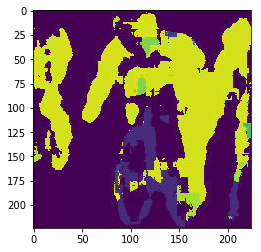

In [41]:
directory = "SavedPredictions/"
folder = "valid4"

inp = misc.imread(directory + folder + "/valid4step72939.jpg")

plt.imshow(inp)

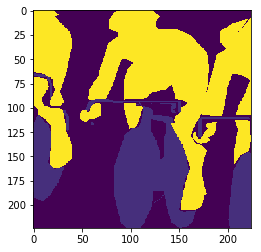

In [49]:
plt.imshow(validation_labels[4].reshape([image_size, image_size]))

In [54]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    
    [p] = session.run(prediction_output, feed_dict={x_input: validation_data[0:6], is_training:False})

# Get Predicted Labels

In [184]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    
    actual_predictions = []
    batch = Batcher(batch_size=1, shuffle=False)
    for x, y in batch(copy.deepcopy(validation_data), copy.deepcopy(validation_labels)):
        actual_predictions.append(session.run(prediction_output, feed_dict={x_input: x, is_training:False}))
    

In [85]:
np.array_equal(np.reshape(training_labels[0], [image_size, image_size]), pred2)

True

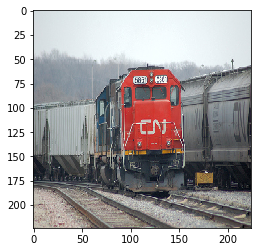

In [133]:
i = 500
plt.imshow(validation_data[i])

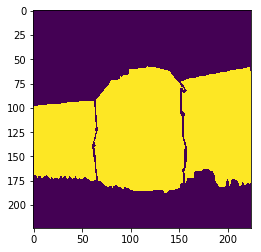

In [134]:
plt.imshow(validation_labels[i])

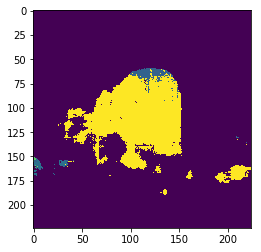

In [136]:
plt.imshow(output_predictions2[i])

# Calculate Results
For calculating the results I save all of the labels in a pickle file. I load the file and organize the classes such that i know which class is predicted for which class label.

In [37]:
def dumpClasses(prediction, label, num_classes):
    class_aggregate = {}
    for i in range(num_classes):
        class_aggregate[i] = {}
        for j in range(num_classes):
            class_aggregate[i][j] = 0
            
    for k in range(len(prediction)):
        for i in range(224):
            for j in range(224):
                class_aggregate[int(label[k][i][j])][int(prediction[k][i][j])] = class_aggregate[int(label[k][i][j])][int(prediction[k][i][j])] + 1
    return class_aggregate

In [ ]:
def get_accuracy(cls):
    sum1 = 0
    sum2 = 0
    for i in range(len(cls)):
        sum1 = sum1 + n[i][i]
    for i in range(len(cls)):
        for j in range(len(cls)):
            sum2 = sum2 + cls[i][j]
    return sum1 / sum2


def get_mean_accuracy(cls):

    t = []
    k = len(n[0])
    for i in range(k):
        t.append(sum([cls[i][j] for j in range(k)])) 
        return (1.0 / k) * sum([float(cls[i][i]) / t[i] for i in range(k)])


def get_mean_iou(n):

    t = []
    k = len(cls[0])
    for i in range(k):
        t.append(sum([cls[i][j] for j in range(k)]))
        
    return (1.0 / k) * sum([float(cls[i][i]) / (t[i] - cls[i][i] + sum([cls[j][i] for j in range(k)])) for i in range(k)])


def get_frequency_weighted_iou(cls):
    t = []
    k = len(cls[0])
    for i in range(k):
        t.append(sum([n[i][j] for j in range(k)]))
    a = sum(t)**(-1)
    b = sum([(t[i] * cls[i][i]) / (t[i] - cls[i][i] + sum([cls[j][i] for j in range(k)])) for i in range(k)])
    return a * b

In [4]:
output_predictions1 = pickle.load(open("stuff/training_labels.pkl", 'rb'))
output_predictions2 = pickle.load(open("stuff/valid_labels.pkl", 'rb'))

In [5]:
output_predictions1 = np.squeeze(output_predictions1)
output_predictions2 = np.squeeze(output_predictions2)

In [83]:
training_class_aggregate = dumpClasses(output_predictions1, training, 151)

In [38]:
validation_class_aggregate = dumpClasses(validation_predictions, validation_labels, 151)

In [44]:
def printResults(class_aggregate):
    print("accuracy:" + str(get_accuracy(class_aggregate)))
    print("mean accuracy:" + str(get_mean_accuracy(class_aggregate)))
    print("mean iou:" + str(get_mean_iou(class_aggregate)))
    print("frequency weighted iou:" + str(get_frequency_weighted_iou(class_aggregate)))

In [45]:
printResults(validation_class_aggregate)

accuracy:0.6306562998246174
mean accuracy:0.2297385692624981
mean iou:0.17560585127043768
frequency weighted iou:0.48047384174287383


In [97]:
printResults(training_class_aggregate)

accuracy:0.9893106048131343
mean accuracy:0.9786119132132034
mean iou:0.9478283287038469
frequency weighted iou:0.9791230318112247
